# Tuning Elo Rankings

This notebook aims to find the best parameters to plug into the Elo model. It makes heavy use of the `elo.py` module which is greatly inspired by the work from this [Kaggle kernel](https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings) which draws inspiration from how [fivethirtyeight](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/) calculates Elo rankings. For more information on the concepts behind the Elo ranking, here is the [Wikipedia](https://en.wikipedia.org/wiki/Elo_rating_system) article on it.

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn import linear_model as lm
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import itertools
cwd = os.getcwd()
# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'
elo_out_dir = cwd+'\\Output\\TestElos\\'
import elo

In [2]:
p = Path('.')
paths = list(p.glob('**/*.csv'))
paths

[WindowsPath('odds_2017_basic.csv'),
 WindowsPath('Input/DataFiles/Cities.csv'),
 WindowsPath('Input/DataFiles/ConferenceTourneyGames.csv'),
 WindowsPath('Input/DataFiles/EloHistory.csv'),
 WindowsPath('Input/DataFiles/GameCities.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySeeds.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySlots.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonCompactResults.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonDetailedResults.csv'),
 WindowsPath('Input/DataFiles/SeasonElos.csv'),
 WindowsPath('Input/DataFiles/SeasonElosK25.csv'),
 WindowsPath('Input/DataFiles/Seasons.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyTeams.csv'),
 WindowsPath('Input/DataFiles/TeamCoaches.csv'),
 WindowsPath('Input/DataFiles/Teams.csv'),
 WindowsPath('Input/DataFiles/Team

In [3]:
### Load Regular Season Results
# Start at 2003 because advanced stats can only be calculated that far back

start = 2003
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c = rs_c.drop(['NumOT'], axis=1)
rs_c = rs_c.reset_index(drop=True)
rs_c.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
82036,2018,132,1153,56,1222,55,N
82037,2018,132,1172,58,1348,57,N
82038,2018,132,1209,74,1426,61,N
82039,2018,132,1246,77,1397,72,N
82040,2018,132,1335,68,1217,65,N


In [4]:
rs_c.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc
0,2003,10,1104,68,1328,62,N
1,2003,10,1272,70,1393,63,N
2,2003,11,1266,73,1437,61,N
3,2003,11,1296,56,1457,50,N
4,2003,11,1400,77,1208,71,N


In [5]:
### Load Tournament Results
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr = tourney_cr.reset_index(drop=True)
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
1043,2018,146,1437,71,1403,59,12
1044,2018,146,1242,85,1181,81,4
1045,2018,152,1276,69,1260,57,12
1046,2018,152,1437,95,1242,79,16
1047,2018,154,1437,79,1276,62,17


### Model Default: K = 20., HCA = 100.

FiveThirtyEight calculates their NBA Elo rankings using the default parameters K = 20 and Homecourt Advantage = 100. College basketball tends to be less deterministic than the NBA in general, so it's worth exploring what parameters work best.

The more frequent fluctuations are due to some key differences between the two leagues:

|                    |                                                                                                                                       NCAA                                                                                                                                      |                                                                                                                                                 NBA                                                                                                                                                 |
|--------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Amount of Games    | ~30-35 regular season games  + up to 5 sudden-death post-season games                                                                                                                                                                                                           | 82 regular season games  + 4 best of 7 post-season games                                                                                                                                                                                                                                            |
| Schedule Imbalance | First half consists of "Non-Conference" games against teams of highly varying talent.  Latter half contains "Conference" games  against teams among the same academic conference. These tend to be less variant than non-conference games but there are typically disparities.  | Each team faces opponents in its own division four times a year (16 games), plays six of the teams from the other two divisions in its conference four times (24 games), the remaining four teams three times (12 games),  and plays all the teams in the other conference twice apiece (30 games). |
| Talent Disparity   | There are 351 Division I NCAA Basketball programs, most of which are from small schools in the country.  The best recruits typically go to the best schools every year. Talent level is less imbalanced in the tournament.                                                      | There are 30 professional NBA teams consisting of the best basketball players in the world.                                                                                                                                                                                                         |
| Roster Turnover    | College players have 4 years of eligibility. College basketball programs have to recruit every year to fill open spots every year.                                                                                                                                              | NBA players stay in the league until they retire. NBA teams can keep their players until either party chooses to part ways.                                                                                                                                                                         |

Because NCAA basketball is more variant, and teams are more inconsistent, I suspect that the optimal K value is higher than the default 20 for the NBA. 

I also suspect that the optimal homecourt advantage is higher than the default 100 for a few hard-to-quantify / anecdotal reasons: 1. College players aren't used to traveling long distances, 2. The stronger, "Power Conference" programs (i.e. the ones with more resources) tend to play host more home games in the non-conference schedule portion than the smaller, typically weaker programs. This disparity in home games would amplify the effect of homecourt advantage.

In [6]:
elos, preds = elo.season_elos(rs=rs_c)

In [7]:
elos.head()

,Season,SeasonElo,TeamID
57902,2014,1408.07,1101
62101,2015,1294.42,1101
68675,2016,1210.1,1101
72986,2017,1238.19,1101
81712,2018,1293.61,1101


In [8]:
elos.tail()

,Season,SeasonElo,TeamID
56457,2014,1455.25,1464
61343,2015,1420.25,1464
66937,2016,1361.7,1464
72302,2017,1334.43,1464
81686,2018,1255.5,1464


In [9]:
elos_tourney = elo.winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'])
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
1042,2018,146,1437,71,1403,59,12,2090.45,1834.38,256.073171
1043,2018,146,1242,85,1181,81,4,1994.26,2010.47,-16.203821
1044,2018,152,1276,69,1260,57,12,1950.42,1728.59,221.831858
1045,2018,152,1437,95,1242,79,16,2090.45,1994.26,96.186820
1046,2018,154,1437,79,1276,62,17,2090.45,1950.42,140.027477


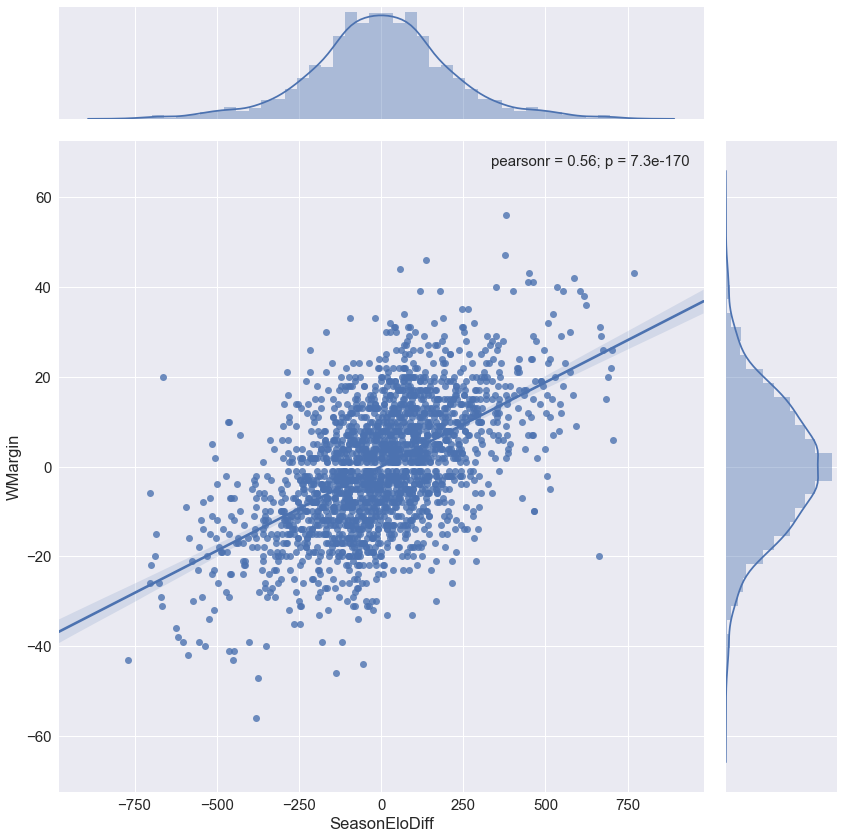

In [10]:
sns.set(font_scale=1.5)

elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)

sns.jointplot(data=elos_tourney, x='SeasonEloDiff', y='WMargin', size=12, kind="reg")

In [11]:
elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)

elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
4183,2018,146,1437,71,1403,59,12,2090.45,1834.38,256.073171
4184,2018,146,1242,85,1181,81,4,1994.26,2010.47,-16.203821
4185,2018,152,1276,69,1260,57,12,1950.42,1728.59,221.831858
4186,2018,152,1437,95,1242,79,16,2090.45,1994.26,96.186820
4187,2018,154,1437,79,1276,62,17,2090.45,1950.42,140.027477


In [12]:
def elo_tune(rs, tourney, Ks, HCAs, x_col='SeasonEloDiff', y_col='WMargin', season_cutoff=2017):
    params = list(itertools.product(Ks, HCAs))
    n_params = len(params)
    scores_all = []
    coefs = []
    for i in range(n_params):
        K, HCA = params[i]
        param_string = "K{}HCA{}".format(K,HCA)
        ### Calculate elos
        elos, rs_preds = elo.season_elos(rs, K, HCA)
        #elos.to_csv(elo_out_dir+"SeasonElos{}.csv".format(param_string))
        
        ### Preprocess elos into [[X][y], [-X],[-y]] form
        elos_tourney = elo.winloss_features(df_teams=tourney, df_feature=elos, feature_cols=['SeasonElo'])
        
        ### Mirror dfs
        elos_tourney = elo.mirror_df(elos_tourney, x=x_col, y=y_col).reset_index(drop=True)
        elos_tourney.to_csv(elo_out_dir+"EloTrain.csv".format(param_string))
        
        ### Evaluate
        scores, coef = elo_lr(elos_tourney, x_col, y_col)
        scores_all.append(scores)
        coefs.append(coef)
        
    return list(zip(params, scores_all)), list(zip(params, coefs))
        
def elo_lr(elos_tourney, x, y, season_cutoff=2017, metrics=[mean_squared_error, explained_variance_score]):
    lr = lm.LinearRegression()
    scores = []
    X_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, x].values.reshape(-1,1)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = elos_tourney.loc[elos_tourney.Season>=season_cutoff, x].values.reshape(-1,1)
    X_test = StandardScaler().fit_transform(X_test)
    y_train = elos_tourney.loc[elos_tourney.Season<season_cutoff, y].values.reshape(-1,1)
    y_train = StandardScaler().fit_transform(y_train)
    y_true = elos_tourney.loc[elos_tourney.Season>=season_cutoff, y].values.reshape(-1,1)
    y_true = StandardScaler().fit_transform(y_true)

    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    coef = lr.coef_
    
    for metric in metrics:
        scores.append(metric(y_true, y_pred))
        
    return scores, coef

In [13]:
### IMPORTANT: THIS CELL IS RESPONSIBLE FOR THE OUTPUT OF DIFFERENT ELO RATINGS.
### BECAUSE IT'S COMPUTATIONALLY EXPENSIVE TO RUN THIS CELL, IT'S ONLY RUN ONCE
### THE OUTPUT AND RESULTS IS IN "scores.npy"

Ks = np.arange(20, 81, 5)
HCAs = np.arange(100, 151, 10)
# scores, coefs = elo_tune(rs_c, tourney_cr, Ks, HCAs, season_cutoff=2017)
# np.save(elo_out_dir+"scores.npy",arr=np.array(scores))

In [14]:
### Compile metric scores, find parameters with the best scores
scores_arr = np.load(elo_out_dir+"scores.npy")
scores_dict = dict()
for arr in scores_arr:
    param, score = arr
    score = list(score)
    param = tuple(param.astype(int))
    
    scores_dict[param] = score

In [15]:
best_params = min(scores_dict, key=scores_dict.get)
print("The best parameters are K = {}, HCA = {} with MSE = {}, R^2 = {}".format(*best_params, *scores_dict[best_params]))

The best parameters are K = 65, HCA = 130 with MSE = 0.6486102183461235, R^2 = 0.35138978165387647


In [16]:
#mean_squared_errors = []
# from collections import Counter
# items = Counter(val[2] for val in dic.values())
mse_dict = dict()
for key,val in scores_dict.items():
    K, HCA = key
    mse, r2 = val
    if K in mse_dict.keys():
        mse_dict[K].append(mse)
    else:
        mse_dict[K] = [mse]

best_mse_per_k = [min(mse_dict[k]) for k in sorted(mse_dict)]

Text(0.5,1,'Mean Squared Error vs. K \nEvaluated on 2017-2018 Tournaments')

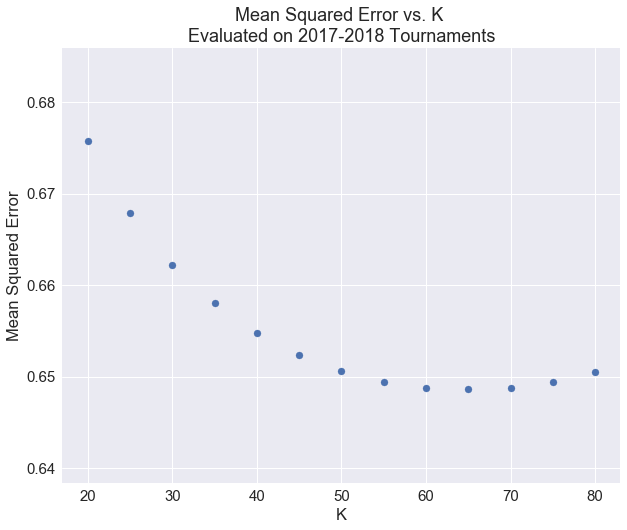

In [17]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
plt.scatter(Ks, best_mse_per_k)
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. K \nEvaluated on 2017-2018 Tournaments')

### Optimal Elo Parameters: K = 65, HCA = 130

In [18]:
elos, preds = elo.season_elos(rs=rs_c, K=65., HOME_ADVANTAGE=130.)
elos_tourney = elo.winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'])
elos_tourney = elo.mirror_df(elos_tourney, x='SeasonEloDiff', y='WMargin').reset_index(drop=True)
elos_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
2089,2018,146,1437,71,1403,59,-12,2188.11,1973.86,-214.248983
2090,2018,146,1242,85,1181,81,-4,2084.82,2082.8,-2.012892
2091,2018,152,1276,69,1260,57,-12,2153.65,1890.91,-262.736135
2092,2018,152,1437,95,1242,79,-16,2188.11,2084.82,-103.289297
2093,2018,154,1437,79,1276,62,-17,2188.11,2153.65,-34.460183


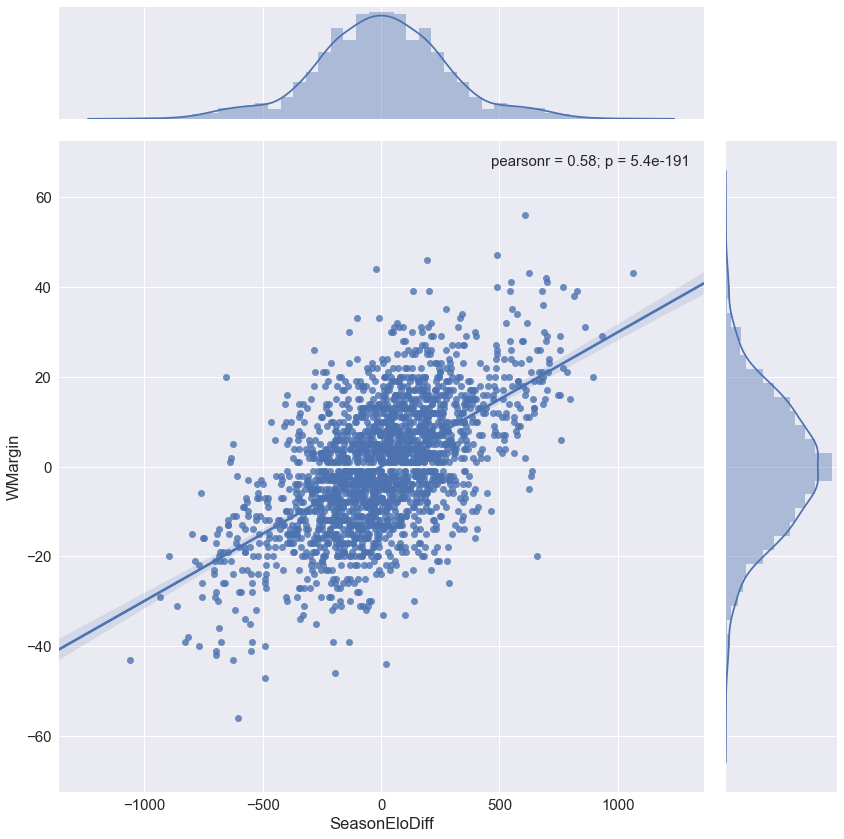

In [19]:
sns.set(font_scale=1.5)
sns.jointplot(data=elos_tourney, x='SeasonEloDiff', y='WMargin', size=12, kind="reg")

In [20]:
elos.to_csv(elo_out_dir+"EloTrainK{}HCA{}.csv".format(*best_params))